In [9]:
!python -m pip install colab-xterm
%load_ext colabxterm
%xterm

!python -m pip install Cython
%cd ./cs6353/
!python setup.py build_ext --inplace
%cd ../

The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


Launching Xterm...

🚀  Listen to 10002
{"success": true, "reason": null}



/home/u1470293/cs6353/assignment4/cs6353
/home/u1470293/cs6353/assignment4


# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [10]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs6353.classifiers.fc_net import *
from cs6353.data_utils import get_CIFAR10_data
from cs6353.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs6353.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# You can ignore the message that asks you to run Python script for now. 
# It will be required in the second part of the assignment.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs6353/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [12]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.75, 0.6, 0.3]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.75
Mean of input:  10.0002078784775
Mean of train-time output:  10.006234670544599
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.749832
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078784775
Mean of train-time output:  10.035153558044966
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.598632
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.3
Mean of input:  10.0002078784775
Mean of train-time output:  10.007776657908957
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.299504
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs6353/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [13]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929048652720146e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:

During training, we randomly drop a fraction p of neurons. If we don’t rescale, the expected output shrinks by a factor of (1−p). For example, with p = 0.5 and an input mean of 10, the output during training has mean ~5 because half the activations are zeroed. But at test time we turn dropout off, so all neurons are active and the mean stays at 10. 

So the weights are learned assuming “smaller” activations, but at test time they suddenly get activations about 1/(1−p) times larger. That scale mismatch hurts performance. Inverted dropout fixes this by dividing by (1−p) during training, so the expected activations match between training and testing, and the same weights work properly in both.


# Fully-connected nets with Dropout
In the file `cs6353/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 0 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [14]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout = 0 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10

Running check with dropout =  0.25
Initial loss:  2.304869215123599
W1 relative error: 6.52e-08
W2 relative error: 1.69e-06
W3 relative error: 5.72e-07
b1 relative error: 5.00e-09
b2 relative error: 1.01e-08
b3 relative error: 1.13e-10

Running check with dropout =  0.5
Initial loss:  2.310136908722148
W1 relative error: 2.57e-08
W2 relative error: 1.49e-08
W3 relative error: 4.49e-08
b1 relative error: 3.93e-10
b2 relative error: 1.91e-09
b3 relative error: 9.51e-11



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [15]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856644
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.878000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.888000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.278000
(Epoch 12 / 25) train acc: 0.962000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.306000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.978000; val_acc: 0.291000
(Epoch 16 / 25) train acc: 0.984000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.986000; v

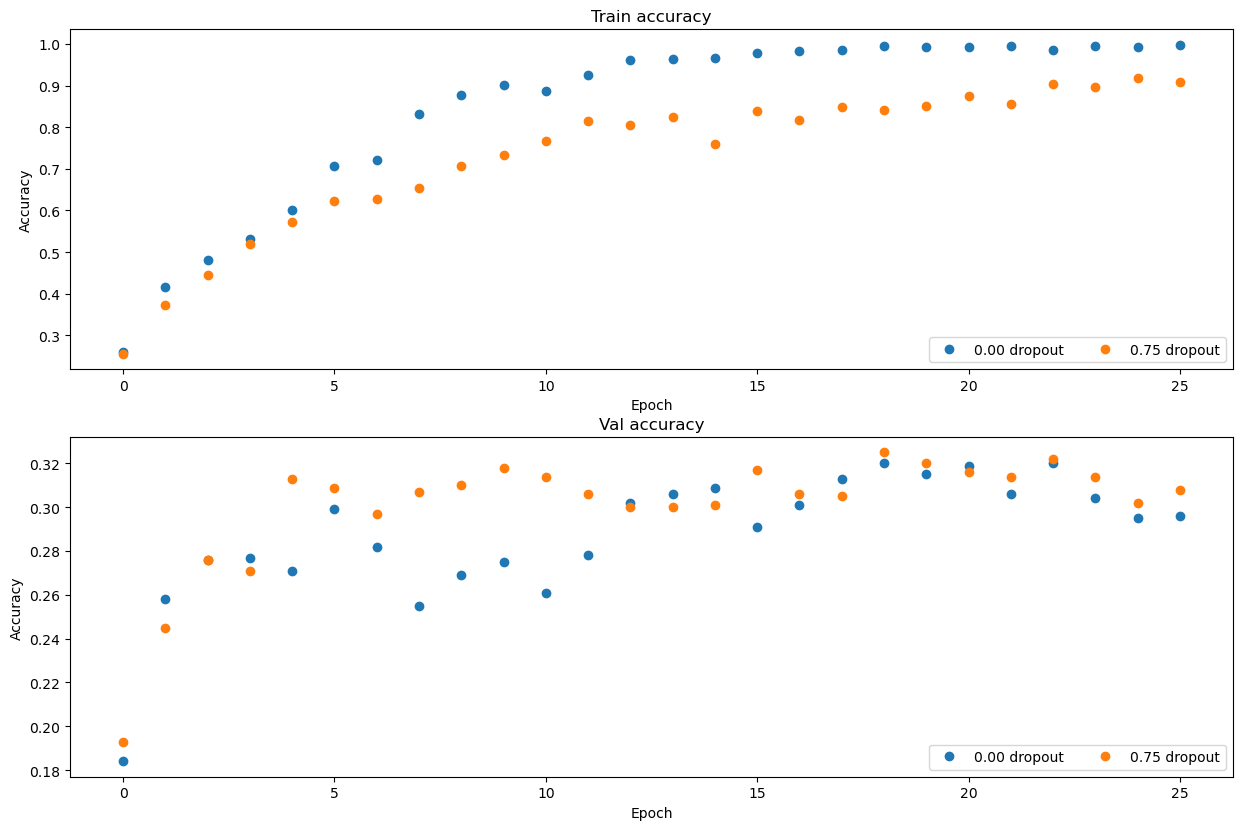

In [16]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
The model without dropout gets very high training accuracy but worse and less stable validation accuracy, which points to overfitting. With dropout (e.g., p = 0.75), training accuracy drops, but validation accuracy is more consistent and closer to the training curve. That smaller gap means the model is generalizing better, even if it "looks worse" on the training set. This trade-off—lower training performance but better generalization—is exactly what we expect from a good regularizer like dropout.

## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by dropout probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
If we make the hidden layers smaller, we should decrease the dropout probability p wich means use less dropout. Big layers have lots of parameters and a high risk of overfitting, so a larger p makes sense. But once the layer is small, the model already has less capacity, and keeping the same high dropout rate can cripple learning and cause underfitting. 